# **1 - Harris Corner Detection**



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = ''


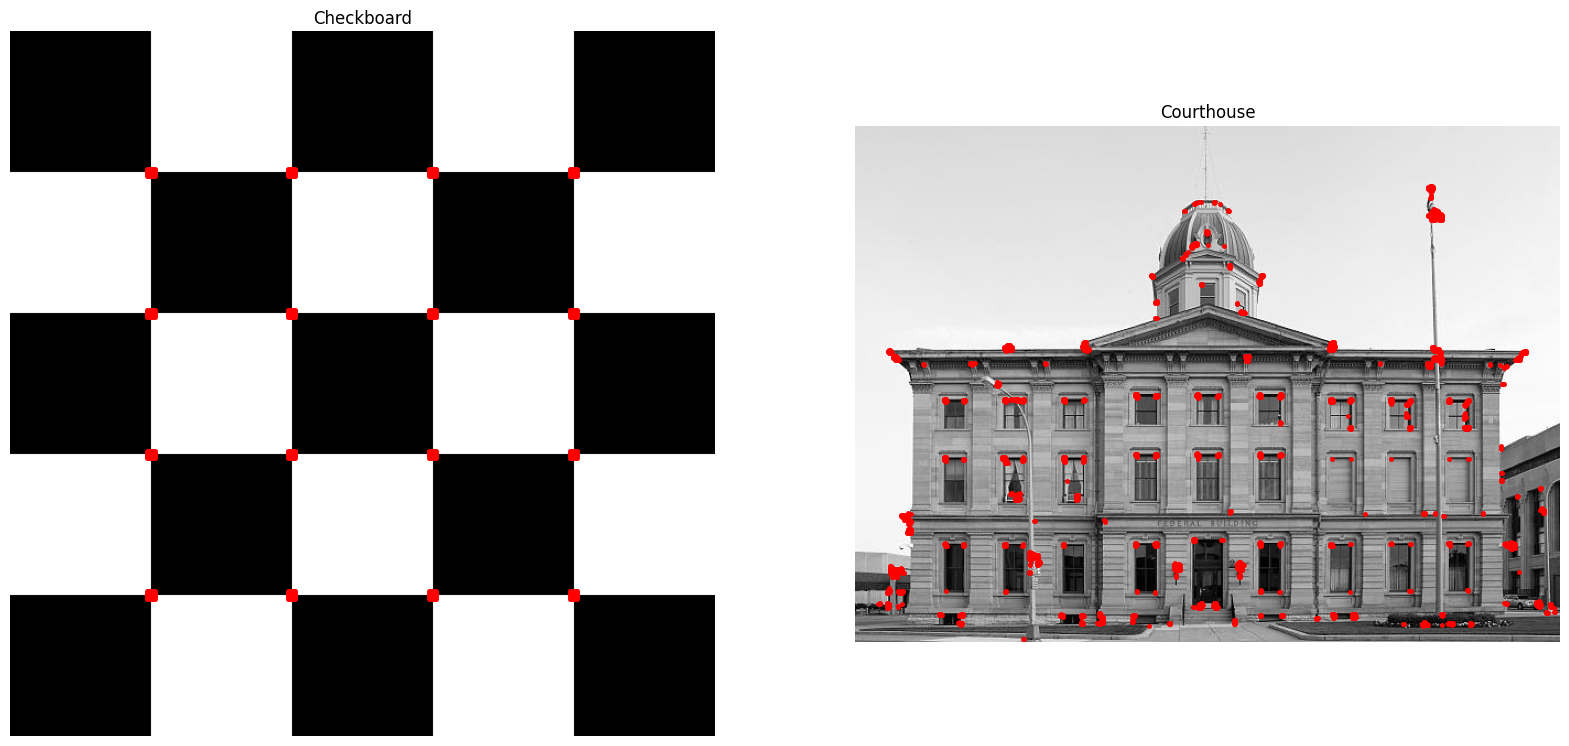

In [2]:


# Function to perform Harris corner detection
def harris_corner_detection(image):

    k=0.05
    threshold=0.05

    # Convert to float
    image = np.float32(image)

    # Apply Gaussian blur to smooth out the image
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # 1 - Compute the image derivatives in both x and y directions
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # 2 - Compute square of derivatives
    Ixx = Ix**2
    Ixy = Ix*Iy
    Iyy = Iy**2

    # 3 - Apply Gaussian filtering to the products of the derivatives to get a sum of products for a window
    Ixx = cv2.GaussianBlur(Ixx, (5, 5), 0)
    Ixy = cv2.GaussianBlur(Ixy, (5, 5), 0)
    Iyy = cv2.GaussianBlur(Iyy, (5, 5), 0)

    # 4 - Compute the Harris response for each pixel
    det = Ixx * Iyy - Ixy**2
    trace = Ixx + Iyy
    response = det - k * (trace**2)

    # 5 - Non-maximum suppression
    # Normalize the response image for thresholding
    response = response / response.max()
    # If the points above the threshold, they are considered corners
    corners = np.argwhere(response > threshold)

    return response, corners


# Load the images
checkboard_image = cv2.imread(path + 'Q1/checkerboard.png', cv2.IMREAD_GRAYSCALE)
courthouse_image = cv2.imread(path + 'Q1/courthouse_gray.jpg', cv2.IMREAD_GRAYSCALE)

# Perform Harris corner detection
checkboard_response, checkboard_corners = harris_corner_detection(checkboard_image)

courthouse_response, courthouse_corners = harris_corner_detection(courthouse_image)


# Plot the images with detected corners

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed

# Image 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(checkboard_image, cmap='gray')
plt.plot([p[1] for p in checkboard_corners], [p[0] for p in checkboard_corners], 'r.', markersize=5)
plt.axis('off')
plt.title('Checkboard')

# Image 2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(courthouse_image, cmap='gray')
plt.plot([p[1] for p in courthouse_corners], [p[0] for p in courthouse_corners], 'r.', markersize=5)
plt.axis('off')
plt.title('Courthouse')

plt.show()




Lowering the threshold value resulted in more pixels being classified as corners. This means that more features were detected in the images, including both true corners and potentially some false positives. The images appeared to have more corners or keypoints.

On the other hand, increasing the threshold value resulted in fewer pixels being classified as corners. This means that fewer features were detected in the images, and some true corners may be missed. The images appeared to have fewer corners or keypoints.

# **2- SIFT Features**


> # **2.1 SIFT in a nutshell**





SIFT (Scale-Invariant Feature Transform) is a method for detecting and describing local features in images, which involves four main steps:

1. **Key Point Detection:** This involves identifying points of interest by finding local maxima and minima in a scale space, which is a pyramid of Difference of Gaussian (DoG) images. This is achieved by first computing smoothed images using Gaussian filtering, then obtaining DoG images by subtracting each smoothed image from the next. Each pixel is then compared with its neighbors to determine if it's a local extremum, which is then classified as a keypoint.

2. **Removing Unstable Keypoints:** Keypoints with a maximum DoG value below a certain threshold are removed to eliminate low contrast points. Non-maximum suppression is also used to remove points along edges and retain corners, similar to the Harris Corner Detector.

3. **Assigning Orientation:** Each keypoint is assigned a canonical orientation based on the most prominent gradient direction in its vicinity. This is determined by creating a weighted histogram of gradient directions, with the weight of each pixel proportional to its magnitude. The canonical orientation is a bin that is at least 80% of the maximum value in the histogram, ensuring rotation invariance.

4. **Creating a SIFT Descriptor:** A descriptor is created for each keypoint to capture information in its surrounding region, ensuring orientation invariance. This involves taking a 16x16 window around the keypoint, dividing it into 16 4x4 subwindows, and calculating the gradient magnitude and orientations in each subwindow. Gaussian weighting is applied to give more weight to points closer to the keypoint. The orientations in each subwindow are put into an 8-bin histogram and smoothed, then concatenated to form a 128-dimensional feature vector. After normalization, this vector forms the 128-dimensional SIFT descriptor for the keypoint.


> # **2.2 SIFT between two different pictures**





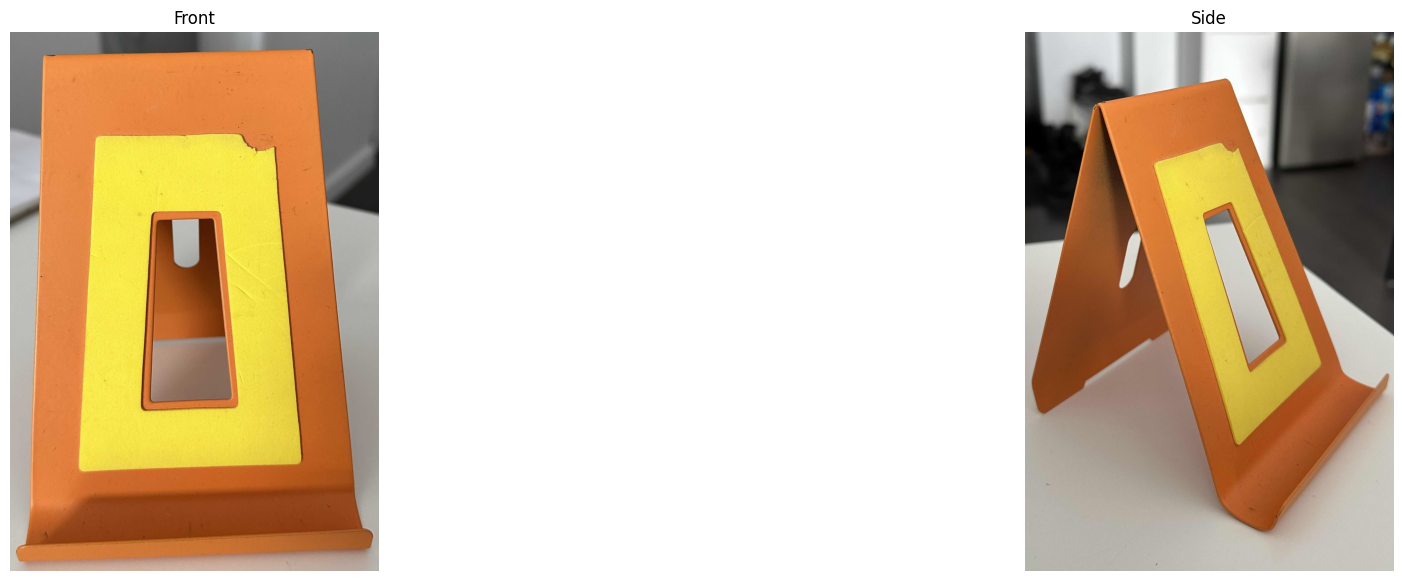

In [3]:

# Load the images
image1 = cv2.imread(path + 'image_1.jpeg')
image2 = cv2.imread(path + 'image_2.jpeg')

#Convert to RGB
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(24, 7))

# Image 1
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.axis('off')
plt.title('Front')

# Image 2
plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.axis('off')
plt.title('Side')

plt.show()



Text(0.5, 1.0, 'Matching Distance for Top 100 SIFT Keypoint Matches')

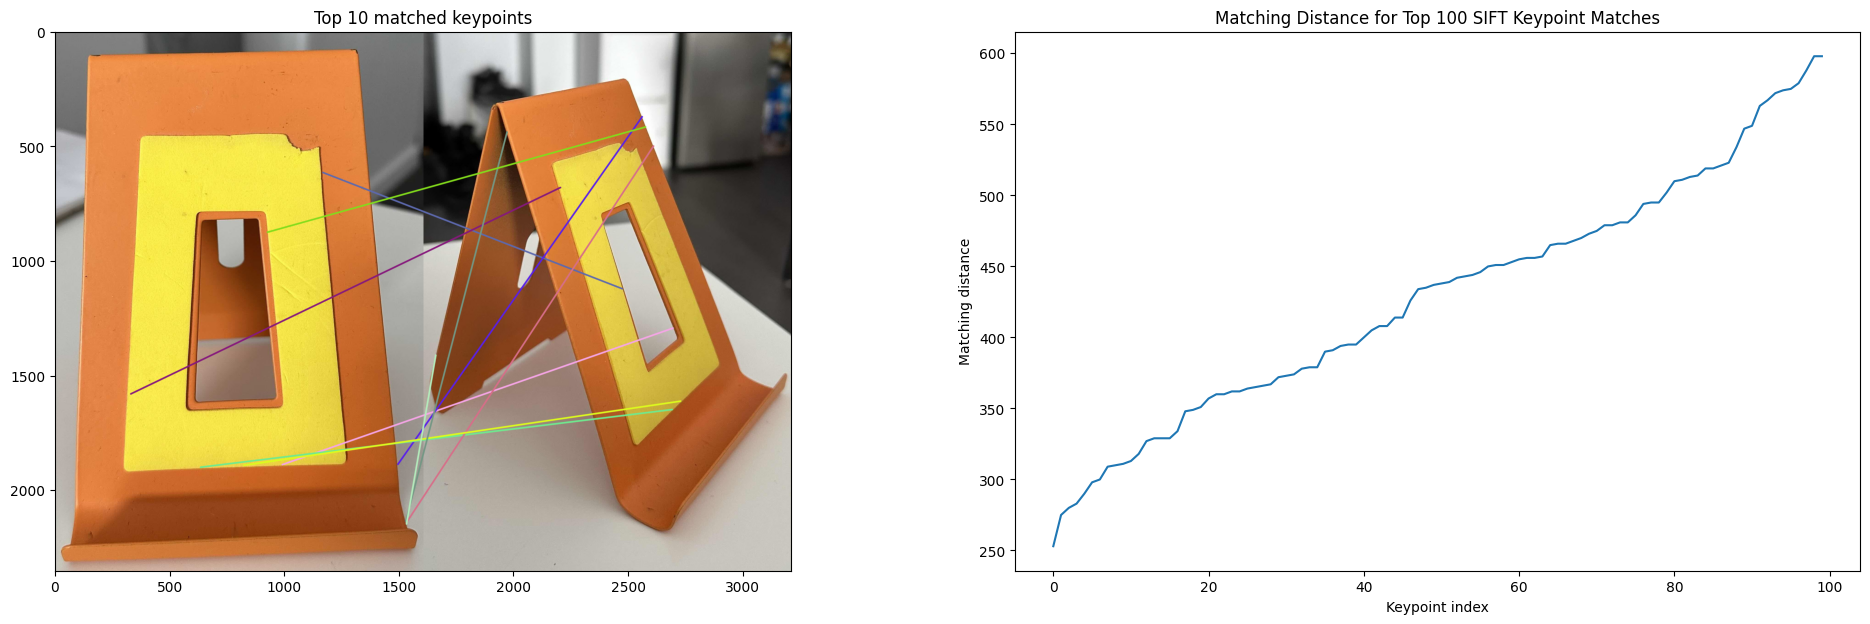

In [4]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# 1 - Detect SIFT features in both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# 2 - Match descriptors
# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# 3 - Sort them in order of their distance
matches = sorted(matches, key = lambda x:x.distance)

# 4- Draw top 10 matches
matching_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,7))

axes[0].imshow(matching_image)
axes[0].set_title('Top 10 matched keypoints')

# 5 - Plotting the distances of the top 100 matched pairs
distances = [matches[i].distance for i in range(100)]
xs = [i for i in range(100)]
axes[1].plot(xs, distances)
axes[1].set_xlabel('Keypoint index')
axes[1].set_ylabel('Matching distance')
axes[1].set_title('Matching Distance for Top 100 SIFT Keypoint Matches')


> # **2.3 Invariance Under Scale**


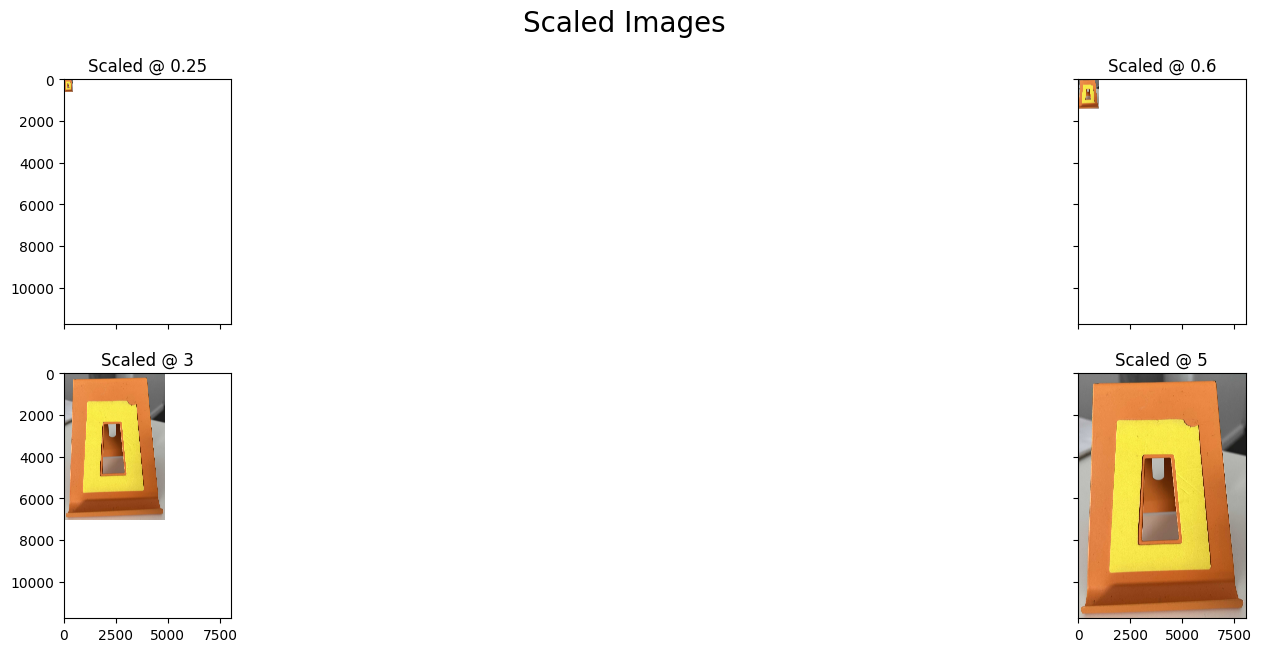

In [5]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# 1 - Detect SIFT features for the original image
originalKeypoints, originalDescriptors = sift.detectAndCompute(image1, None)

# Scale factors
scaleFactors = [0.25, 0.6, 3, 5]

# Initialize lists for images
images_scaled = []

# 2 - Scale the image 
for scale in scaleFactors:

  tempImage = cv2.resize(image1, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
  images_scaled.append(tempImage)

# Plot the scaled images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 7), sharex=True, sharey=True)
fig.suptitle('Scaled Images',fontsize=20)
for i, scaled_image in enumerate(images_scaled):
  row = i // 2
  col = i % 2
  axes[row, col].imshow(scaled_image)
  axes[row, col].set_title("Scaled @ " + str(scaleFactors[i]))
plt.show()



In [6]:
keypoints_scaled = []
descriptors_scaled = []

# 3 - Detect SIFT features for the scaled images
# It's in a different cell because it takes a while to compute
for tempImage in images_scaled:

  tempKeypoints, tempDescriptors = sift.detectAndCompute(tempImage, None)
  keypoints_scaled.append(tempKeypoints)
  del tempKeypoints
  descriptors_scaled.append(tempDescriptors)
  del tempDescriptors


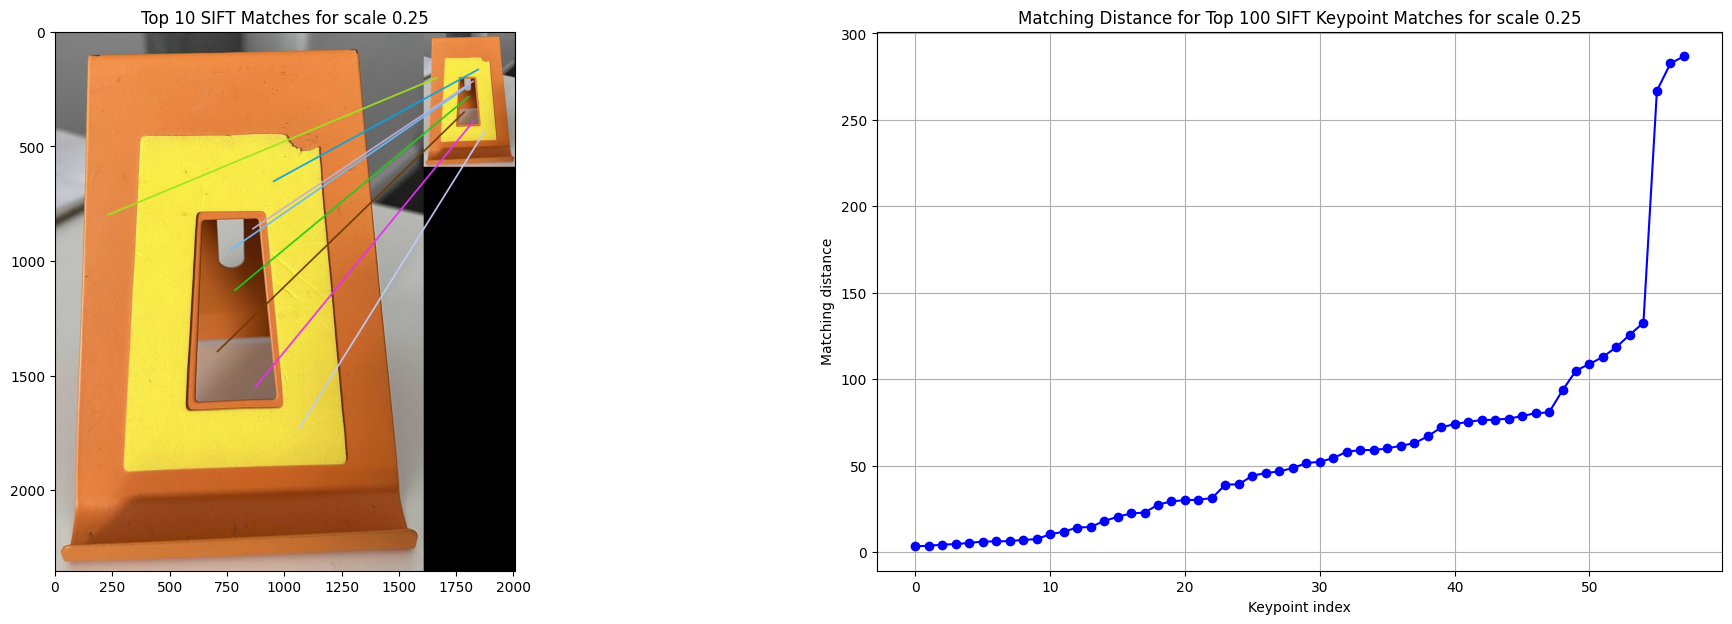

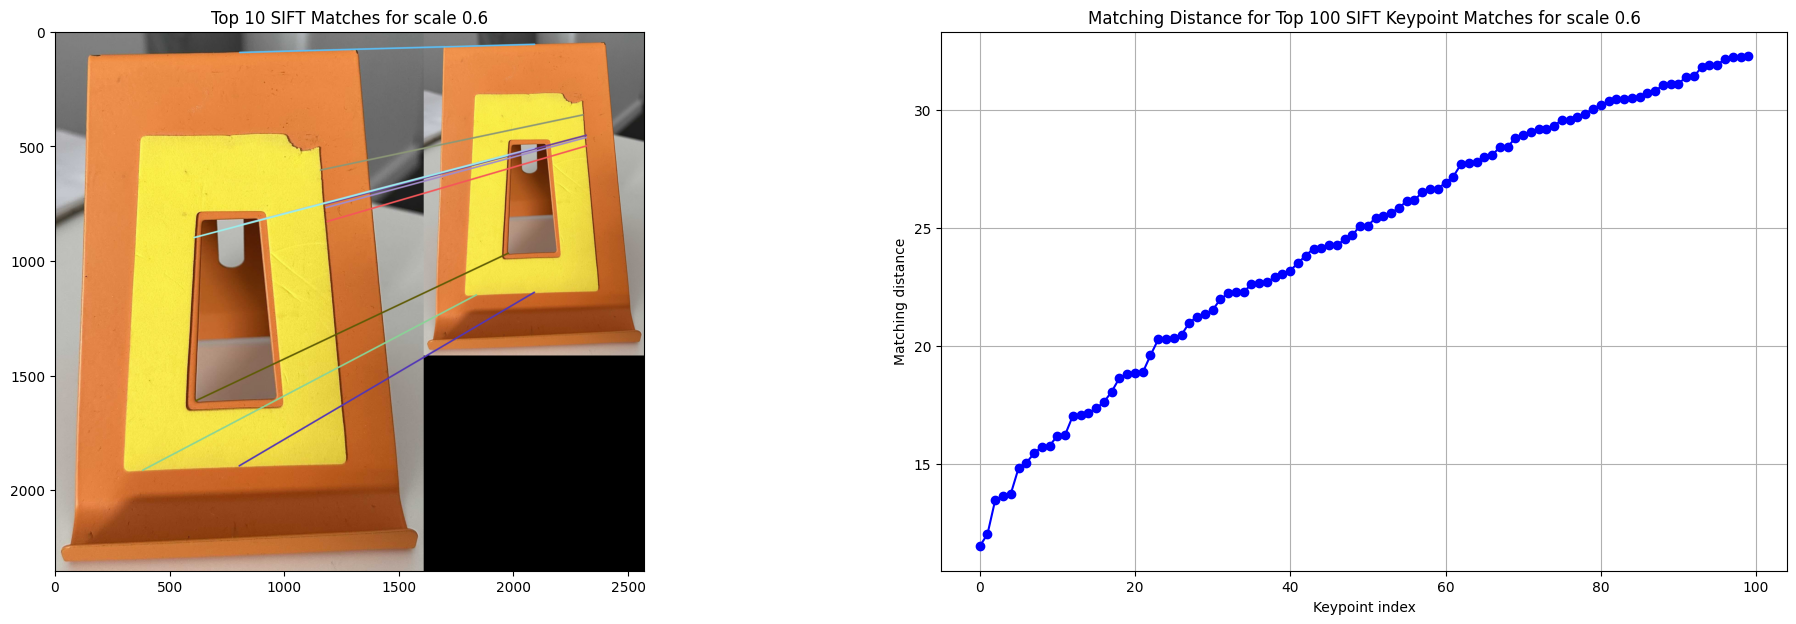

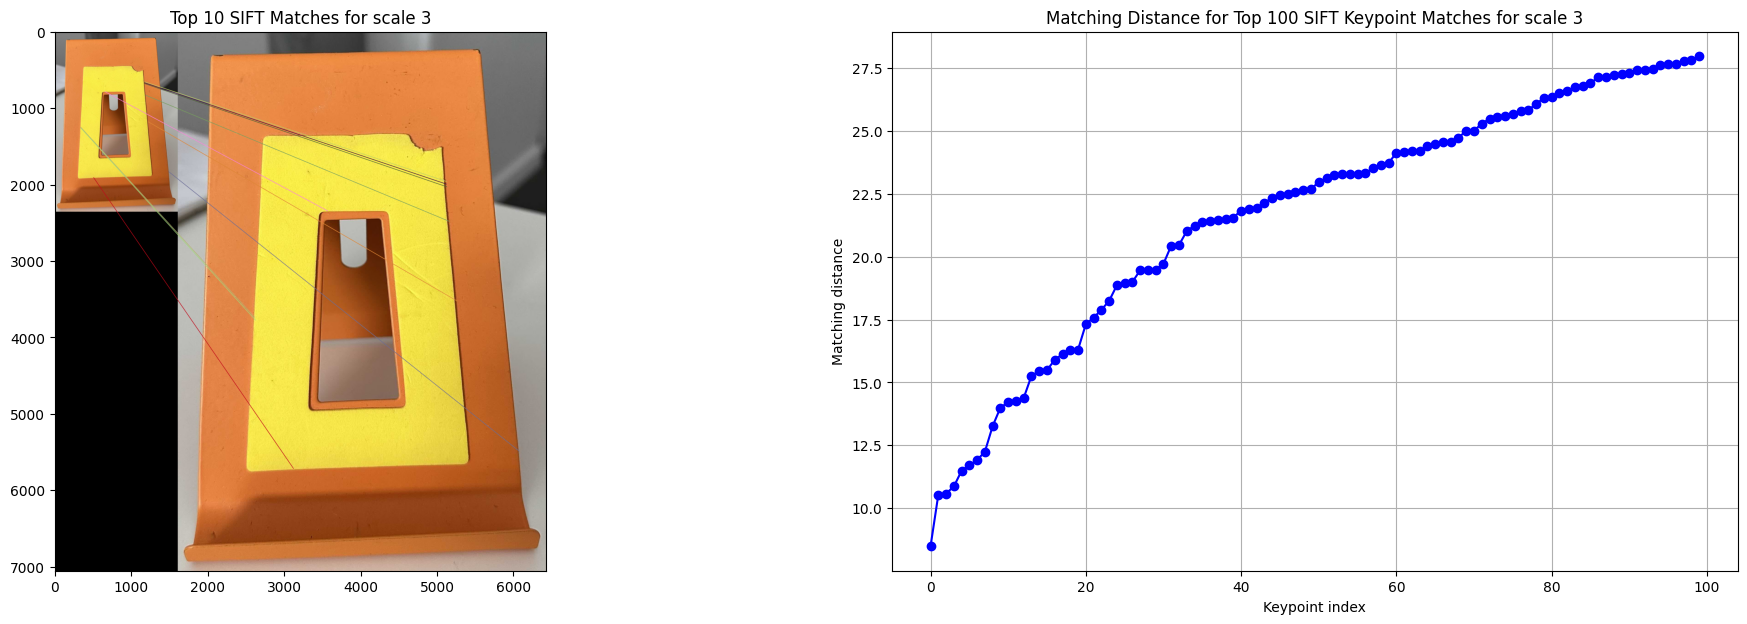

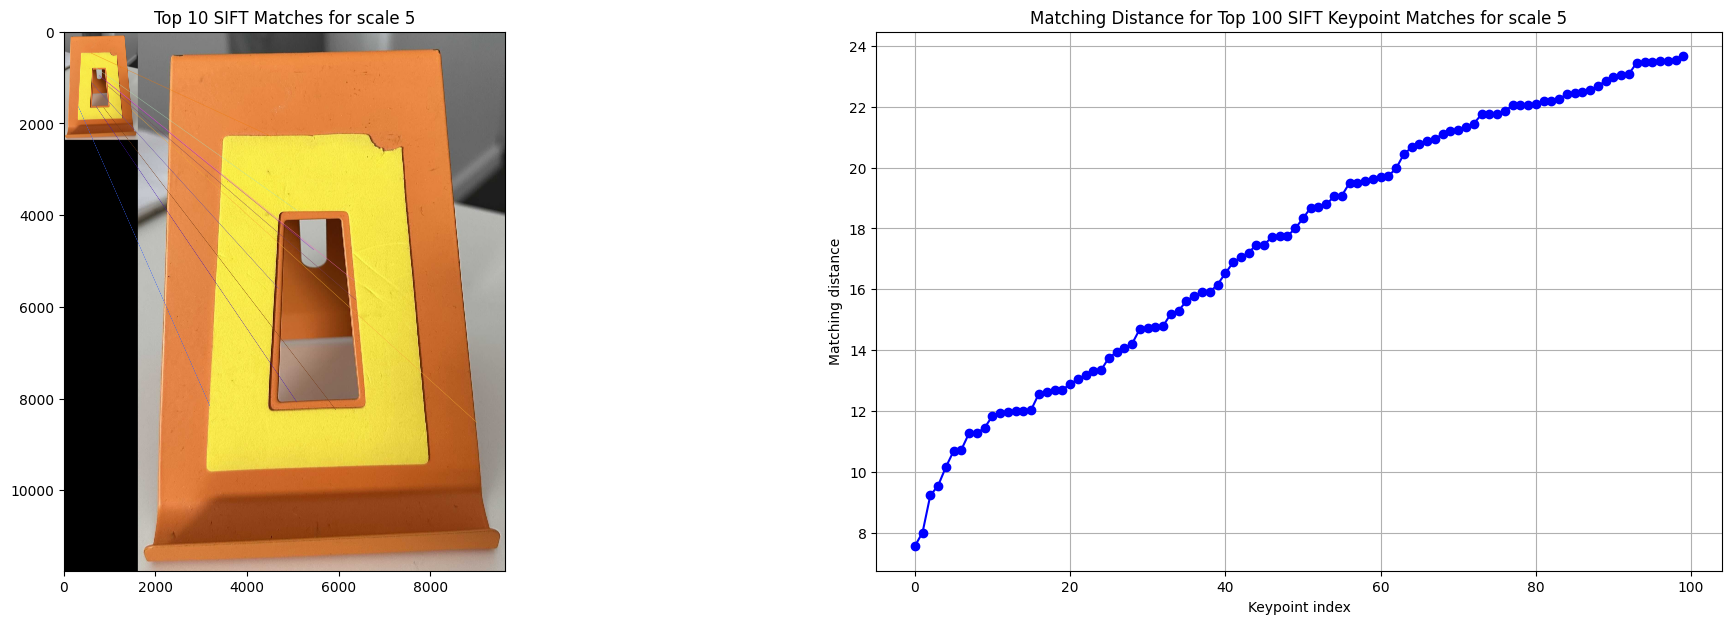

In [7]:
def sift_and_match_scale(image1, kp1, desc1, scale, i):
    # Resize image
    scaled_image = images_scaled[i]

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # 4 - Match descriptors
    matches = bf.match(desc1, descriptors_scaled[i])

    # 5 - Sort the matching keypoints according to the matching distance
    matches = sorted(matches, key=lambda x: x.distance)

    # 6 - Draw first 10 matches.
    img_matches = cv2.drawMatches(image1, kp1, scaled_image, keypoints_scaled[i], matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=5)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,7))

    axes[0].imshow(img_matches)
    axes[0].set_title(f'Top 10 SIFT Matches for scale {scale}')

    # 7 - Plot the matching distance for the top 100 matched keypoints
    top_100_matches = matches[:100]
    distances = [m.distance for m in top_100_matches]
    indices = range(len(distances))

    axes[1].plot(indices, distances, 'bo-')
    axes[1].set_xlabel('Keypoint index')
    axes[1].set_ylabel('Matching distance')
    axes[1].set_title(f'Matching Distance for Top 100 SIFT Keypoint Matches for scale {scale}')
    axes[1].grid(True)


# Perform the SIFT detection, scaling, and matching for each scale factor
for i, scale_factor in enumerate(scaleFactors):
    sift_and_match_scale(image1, originalKeypoints, originalDescriptors, scale_factor, i)


As the scale increase, the distance between matching keypoints reduces. This is because keypoints in the scaled images become more similar to those in the original image.

However, large scales can be problematic: this resulted in an increase in matching distances due to information loss (0.25x or 5x).

Additionally, it's observed that the matching distance between keypoints escalates more rapidly as the image scale grows.

> # **2.4 Invariance Under Rotation**


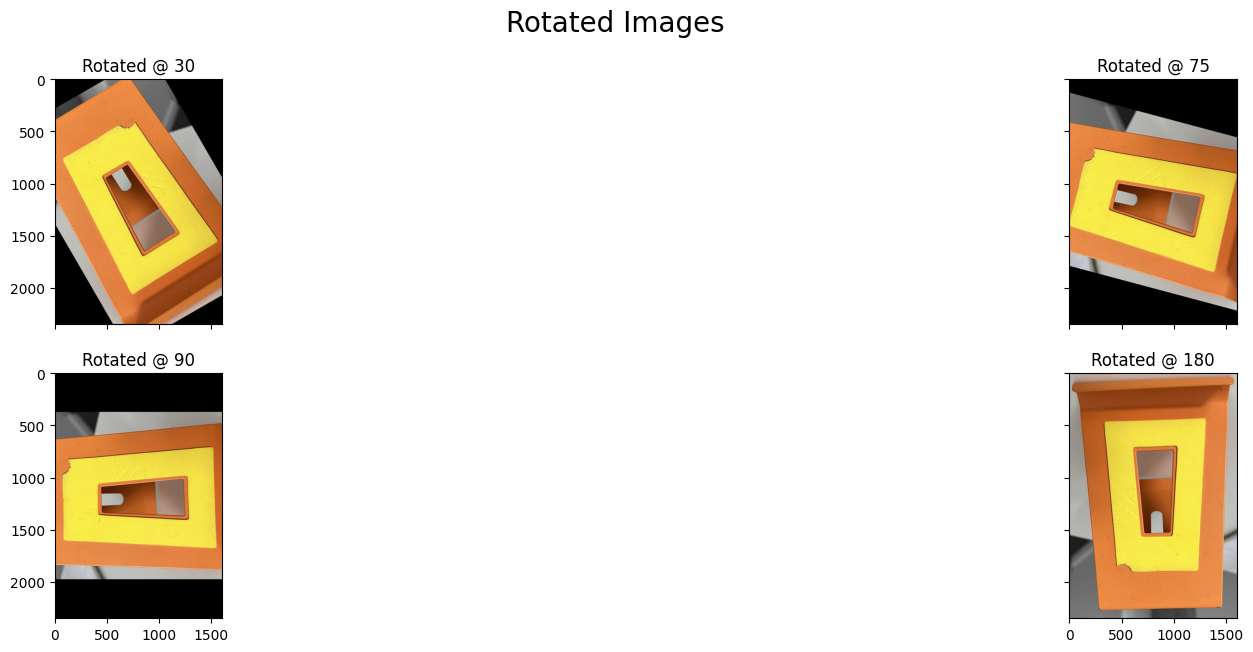

In [8]:
# Scale factors
angleRotation = [30, 75, 90, 180]

# Initialize lists for images
images_rotated = []

# 1 - Rotate the image 
for angle in angleRotation:
  
# Get the center of the image
  height, width = image1.shape[:2]
  center = (width // 2, height // 2)

  # Define the rotation matrix
  rotation = cv2.getRotationMatrix2D(center, angle, 1.0)

  tempImage = cv2.warpAffine(image1, rotation, (width, height))

  images_rotated.append(tempImage)

# Plot the scaled images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 7), sharex=True, sharey=True)
fig.suptitle('Rotated Images',fontsize=20)
for i, tempImage in enumerate(images_rotated):
  row = i // 2
  col = i % 2
  axes[row, col].imshow(tempImage)
  axes[row, col].set_title("Rotated @ " + str(angleRotation[i]))
plt.show()


In [9]:
keypoints_rotated = []
descriptors_rotated = []

# 2 - Detect SIFT features for the rotated images
# It's in a different cell because it takes a while to compute
for tempImage in images_rotated:

  tempKeypoints, tempDescriptors = sift.detectAndCompute(tempImage, None)
  keypoints_rotated.append(tempKeypoints)
  del tempKeypoints
  descriptors_rotated.append(tempDescriptors)
  del tempDescriptors


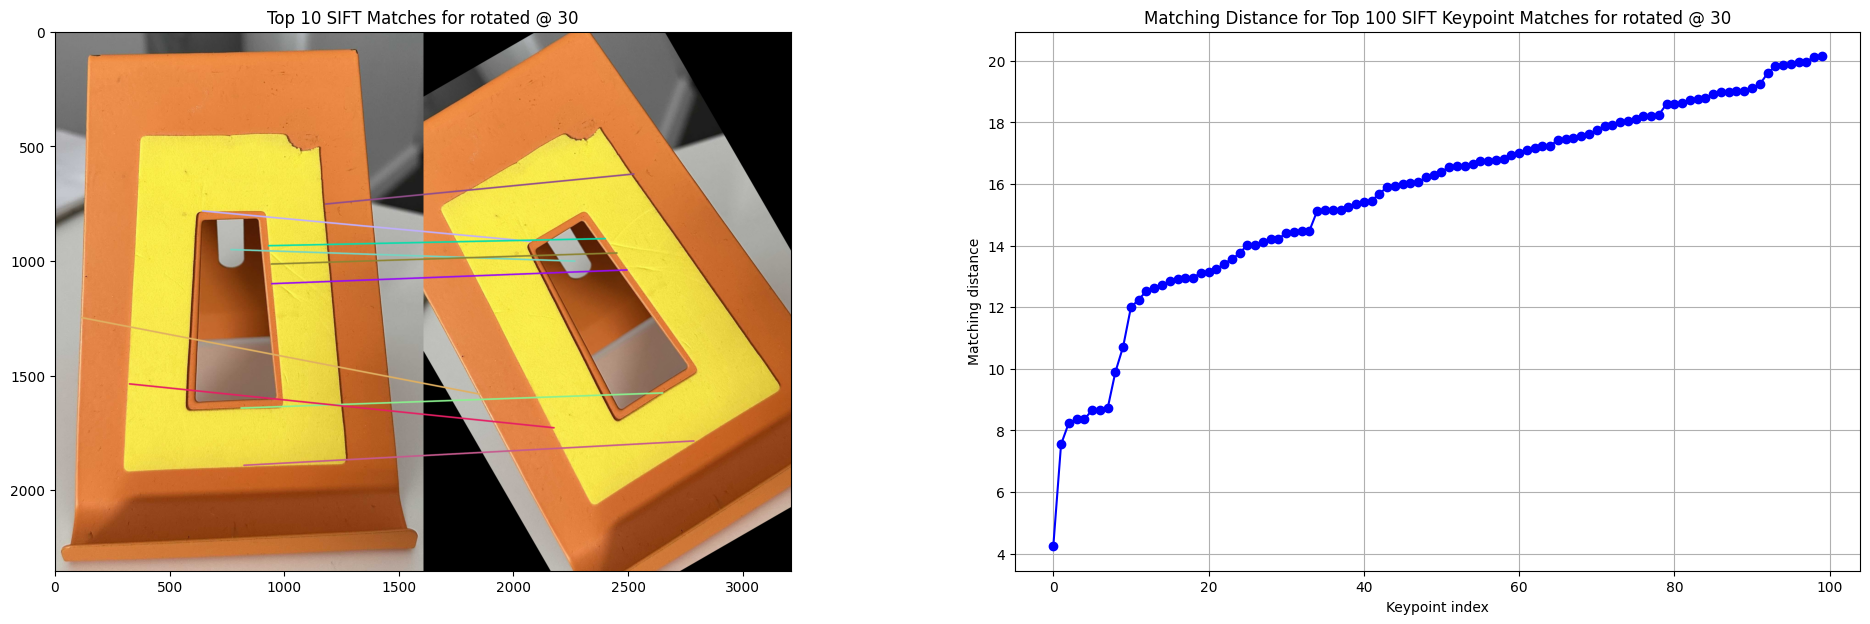

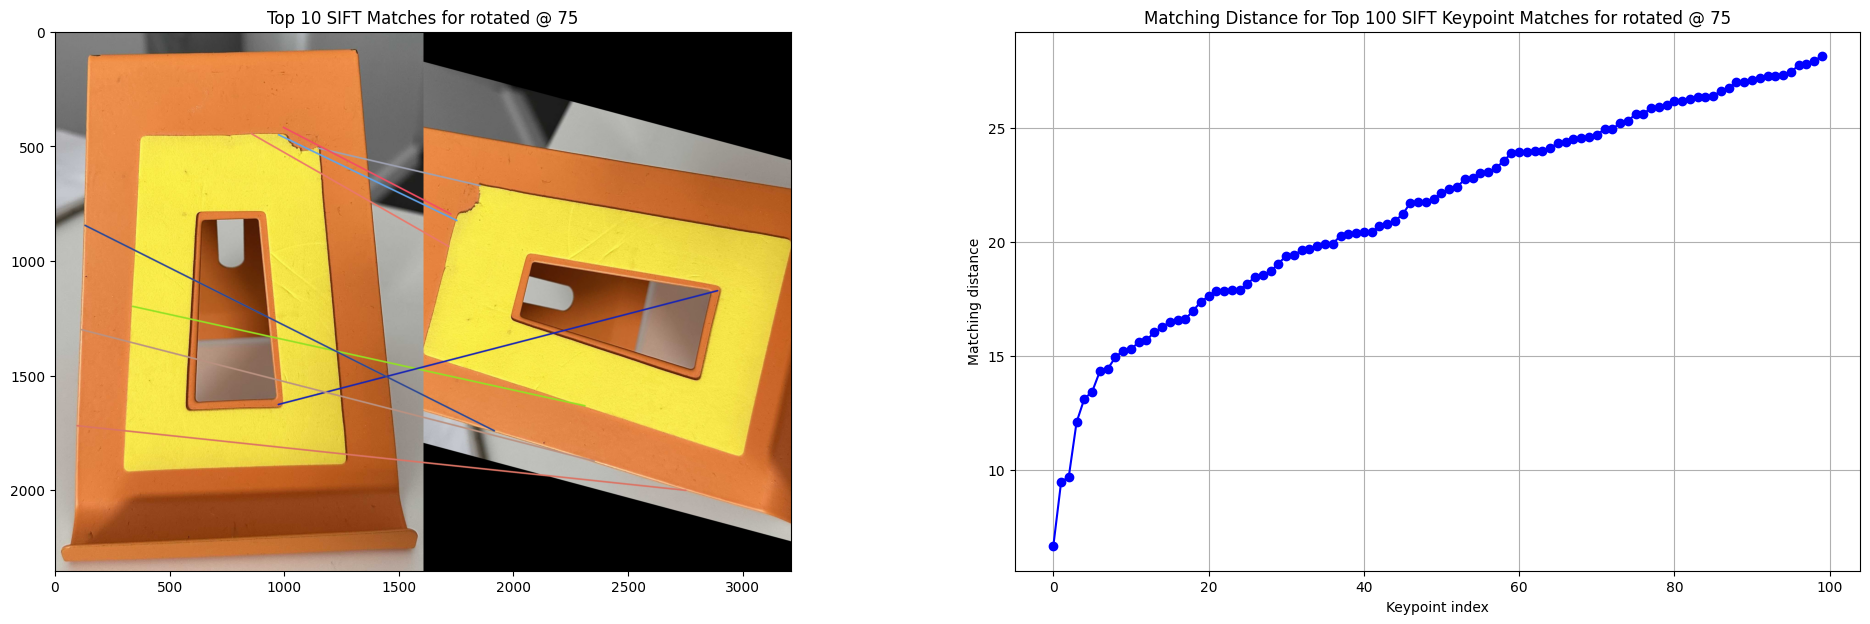

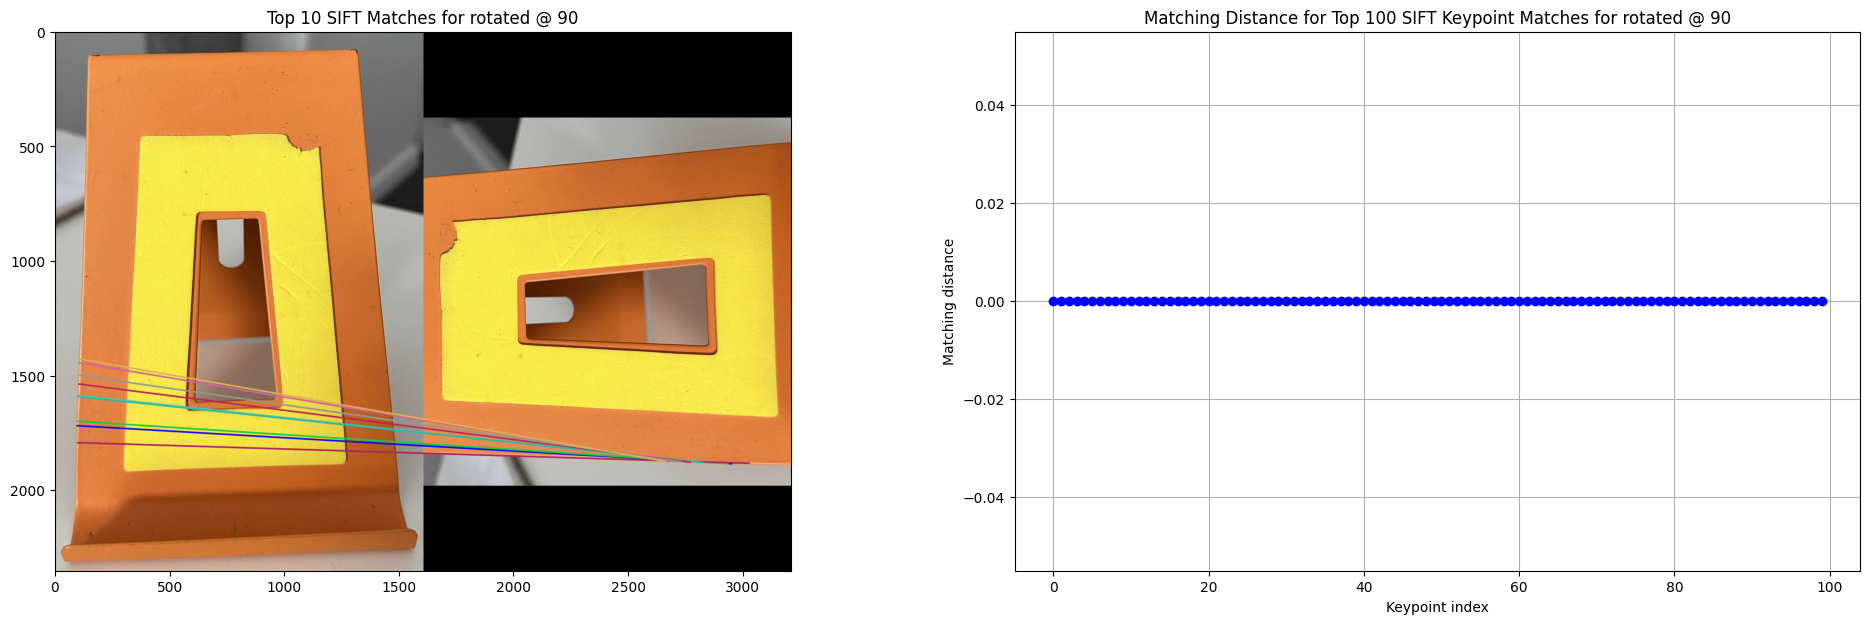

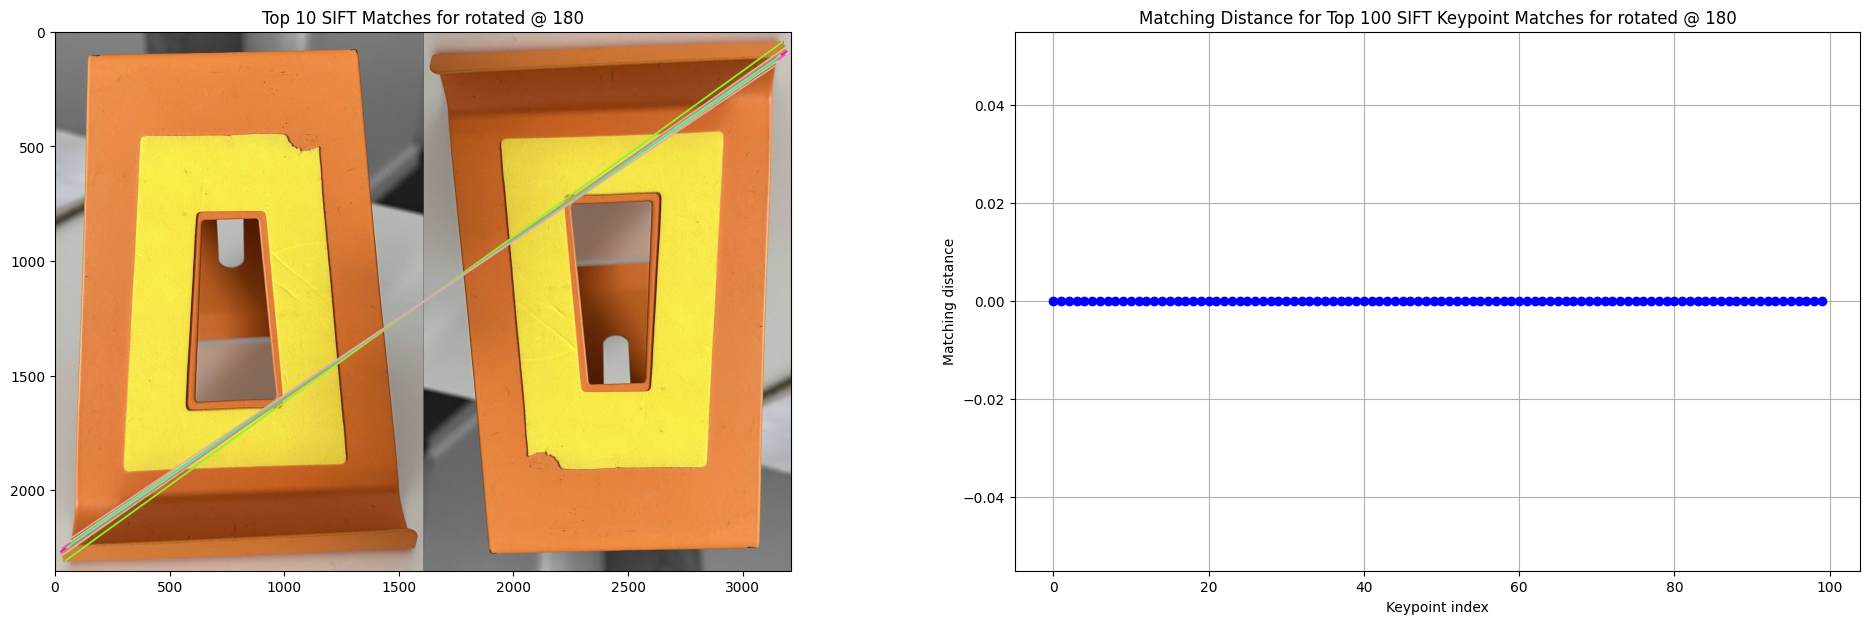

In [10]:
def sift_and_match_rotated(image1, kp1, desc1, angle, i):
    # Resize image
    rotated_image = images_rotated[i]

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # 3 - Match descriptors
    matches = bf.match(desc1, descriptors_rotated[i])

    # 4 - Sort the matching keypoints according to the matching distance
    matches = sorted(matches, key=lambda x: x.distance)

    # 5 - Draw first 10 matches.
    img_matches = cv2.drawMatches(image1, kp1, rotated_image, keypoints_rotated[i], matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=5)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,7))

    axes[0].imshow(img_matches)
    axes[0].set_title(f'Top 10 SIFT Matches for rotated @ {angle}')

    # 6 - Plot the matching distance for the top 100 matched keypoints
    top_100_matches = matches[:100]
    distances = [m.distance for m in top_100_matches]
    indices = range(len(distances))

    axes[1].plot(indices, distances, 'bo-')
    axes[1].set_xlabel('Keypoint index')
    axes[1].set_ylabel('Matching distance')
    axes[1].set_title(f'Matching Distance for Top 100 SIFT Keypoint Matches for rotated @ {angle}')
    axes[1].grid(True)


# Perform the SIFT detection, rotating, and matching for each angle factor
for i, angle in enumerate(angleRotation):
    sift_and_match_rotated(image1, originalKeypoints, originalDescriptors, angle, i)

If the rotation is a multiple of 90 degree, the distance is exactly 0. Otherwise, the distance increases at a similar rate of the angle

# **3- Image Stitching**


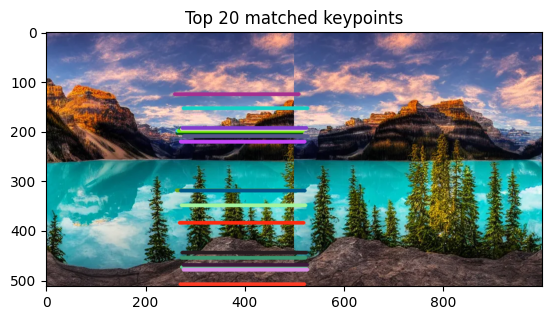

In [11]:

# Load the images
image1 = cv2.imread(path + 'Q3/part1.png')
image2 = cv2.imread(path + 'Q3/part2.png')

# Convert the images to RGB
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


# Create SIFT feature detector
sift = cv2.SIFT_create()

# a - Detect SIFT features and compute descriptors for the two images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# b - Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort the matching keypoints according to the matching distance
matches = sorted(matches, key = lambda x:x.distance)

# Select the 20 best matches
# Display the best matching points
matching_result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=5)

plt.figsize=(24, 7)
plt.title('Top 20 matched keypoints')
plt.imshow(matching_result) 
plt.show()





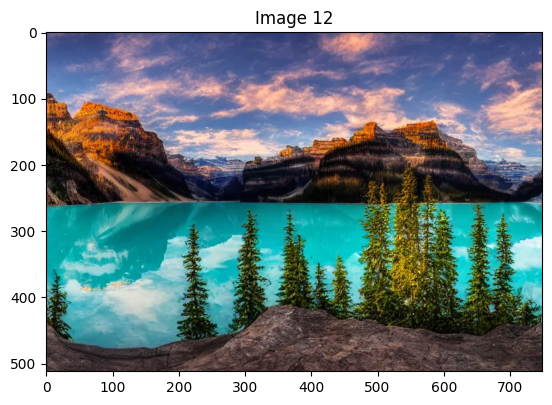

In [12]:

# c - Create empty arrays to store the matched keypoints
points1 = np.zeros((len(matches[:20]), 2), dtype=np.float32)
points2 = np.zeros((len(matches[:20]), 2), dtype=np.float32)

# Extract the coordinates of the matched keypoints
for i, match in enumerate(matches[:20]):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Adjust the x-coordinates of points1 to account for the width of image1
points1[:, 0] -= image1.shape[1]

# Find the homography matrix using RANSAC algorithm
H_12, temp = cv2.findHomography(points1, points2, cv2.RANSAC, 4)

# Warp image1 using the homography matrix
image1Trans = cv2.warpPerspective(image1, H_12, (image1.shape[1], image2.shape[0]))

# Calculate the width of the homography region
homography_width = int(abs(H_12[0, 2]))

# Calculate the combined width of the stitched image
combined_width = int(image2.shape[1] + homography_width)

# Create a temporary image with the same height
tempImage1Trans = np.zeros((image1Trans.shape[0], combined_width, 3), dtype=np.uint8)

# Copy the warped image1Trans to the left side of tempImage1Trans
tempImage1Trans[:, :homography_width] = image1Trans[:, -homography_width:]

# Create a temporary image with the same height as image2 and combined_width
tempImage2 = np.zeros((image2.shape[0], combined_width, 3), dtype=np.uint8)

# Copy image2 to the right side
tempImage2[:, -image2.shape[1]:] = image2

# d - Combine the images using alpha blending
image12 = cv2.addWeighted(tempImage1Trans, 1, tempImage2, 1, 0)

# Display the stitched image
plt.title('Image 12')
plt.imshow(image12)
plt.show()

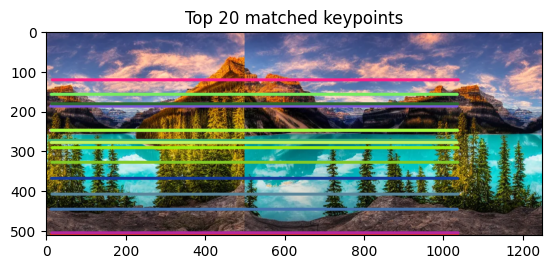

In [13]:

# Load the images
image3 = cv2.imread(path + 'Q3/part3.png')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

# Create SIFT feature detector
sift = cv2.SIFT_create()

# f - Detect SIFT features and compute descriptors for the two images
keypoints3, descriptors3 = sift.detectAndCompute(image3, None)
keypoints12, descriptors12 = sift.detectAndCompute(image12, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors3, descriptors12)
matches = sorted(matches, key = lambda x:x.distance)

# f - Select the 20 best matches
# Display the best matching points
matching_result = cv2.drawMatches(image3, keypoints3, image12, keypoints12, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=5)

plt.figsize=(24, 7)
plt.title('Top 20 matched keypoints')
plt.imshow(matching_result) 
plt.show()


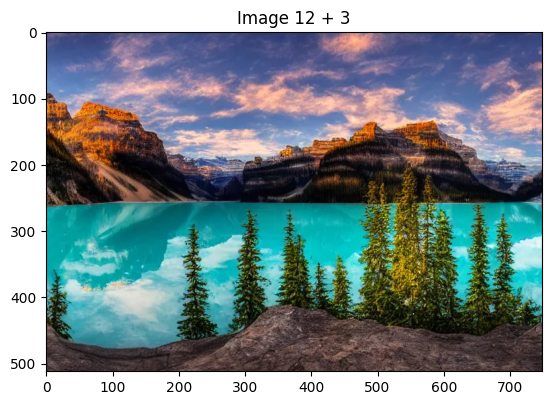

In [14]:
# g - and h - 

points12 = np.zeros((len(matches[:20]), 2), dtype=np.float32)
points3 = np.zeros((len(matches[:20]), 2), dtype=np.float32)

for i, match in enumerate(matches[:20]):
    points12[i, :] = keypoints1[match.queryIdx].pt
    points3[i, :] = keypoints2[match.trainIdx].pt

points12[:, 0] -= image1.shape[1]

H_12, temp = cv2.findHomography(points12, points3, cv2.RANSAC, 4)

image3Trans = cv2.warpPerspective(image3, np.linalg.inv(H_12), (image3.shape[1], image3.shape[0]))

homography_width = int(abs(H_12[0, 2]))
combined_width = int(image12.shape[1] + homography_width)


tempImage3Trans = np.zeros((image3Trans.shape[0], combined_width, 3), dtype=np.uint8)
tempImage3Trans[:, :homography_width] = image3Trans[:, -homography_width:]


tempImage12 = np.zeros((image12.shape[0], combined_width, 3), dtype=np.uint8)
tempImage12[:, -image12.shape[1]:] = image12

image123 = cv2.addWeighted(tempImage3Trans, 1, tempImage12, 1, 0)

plt.title('Image 12 + 3')
plt.imshow(image12)
plt.show()

The choice between these techniques depends on the specific requirements of the blending task:

Pyramid blending is preferred over linear blending when:

1. There are significant differences in content between the images, such as different objects or scenes.
2. There are significant differences in lighting conditions or color distributions between the images.
3. High-quality blending with smooth transitions and preserved details is desired.
4. The computational cost of pyramid blending is acceptable for the specific application.

However, pyramid blending can be more computationally intensive compared to linear blending, as it involves the construction and manipulation of image pyramids. Therefore, if the images have similar content and there are no significant differences in lighting conditions or color distributions, linear blending can be a more efficient and suitable choice.